In [1]:
from evoframe.reward_builders import RewardBuilderGame
from evoframe.population_update_builders import PopulationUpdateBuilderStatic
from evoframe.selector_function import SelectorFunctionFactory
from evoframe import PopulationManager
from evoframe.models import FeedForwardNetwork
from evoframe.models import ActivationFunctions
from evoframe.games import GuessPoint
from evoframe.games import Game
from evoframe import get_agent_wrapper_func
import evoframe.func_with_context as fwc

from itertools import product
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def plot_rewards(env):
    num_epochs = len(env["rewards"].keys())
    xs = np.arange(num_epochs)
    ys = [rs[0] for rs in env["rewards"].values()]
    plt.plot(xs, ys)

In [3]:
import collections

def recursively_default_dict():
    return collections.defaultdict(recursively_default_dict)

In [11]:
def plot_delta_rewards_by_operator(context, hist_range, save=False):
    num_epochs = len(context["epochs"])
    is_first = True
    all_operators = list(set(context["epochs"][2]["operators"]))
    num_cols = len(all_operators)
    num_rows = num_epochs - 1

    plt.figure(figsize=(16, num_rows*4))

    for i_epoch, epoch in context["epochs"].items():
        models = epoch["models"]
        rewards = epoch["rewards"]
        operators = epoch["operators"]

        if is_first:
            is_first = False
        else:
            delta_rewards = [r - prev_best_rewards for r in rewards]
            d_rewards = {op:[] for op in all_operators}
            for i in range(len(models)):
                d_rewards[operators[i]] += [delta_rewards[i]]
            for i,op in enumerate(all_operators):
                cell = (i_epoch - 2)*3 + i + 1
                plt.subplot(num_rows, num_cols, cell)
                plt.title("Epoch {} - Operator {}".format(i_epoch, op))
                plt.hist(d_rewards[op], 50, range=hist_range)

        prev_best_rewards = max(rewards)

    if save:
        plt.savefig("guessfunction.png")
    else:
        plt.show()

# Guess the point

In [ ]:
# Define global context
context = recursively_default_dict()

# Game
game_creation_func = lambda context: GuessPoint(np.array([0.2,0.8,0.5]), np.array([0.4, 0.5, 10]))
game_creation_func = fwc.func_with_context(game_creation_func, context=context)

# Model
layer_sizes = [3, 5, 3]
get_model_func = lambda context: FeedForwardNetwork(layer_sizes, ActivationFunctions.get_sigmoid(), ActivationFunctions.get_id())
get_model_func = fwc.func_with_context(get_model_func, context=context)

# Game-Model interface
predict_func = lambda model, inputs: model.predict(inputs)
agent_wrapper_func = get_agent_wrapper_func(predict_func)

# Reward function and update env function
reward_function = RewardBuilderGame() \
.with_game_creation_function(game_creation_func) \
.with_agent_wrapper_func(agent_wrapper_func) \
.with_context(context) \
.get()

# Update population function
mutation_perc = 0.6
crossover_perc = 0.3
copy_perc = 0.1
get_new_pop_f = PopulationUpdateBuilderStatic() \
.add_operator("es_1_mutation", mutation_perc, 0.3, 0.3) \
.add_operator("es_2_crossover", crossover_perc, 0.8) \
.add_operator("es_1_copy", copy_perc) \
.add_selector_f(SelectorFunctionFactory.get_geometric_selector_function(0.3)) \
.with_context(context) \
.get()

# Population manager
pop_size = 500
pm = PopulationManager(pop_size, get_model_func, reward_function, get_new_pop_f, context)

# Run population manager
num_epochs = 10
last_pop = pm.run(num_epochs)

In [ ]:
plot_delta_rewards_by_operator(context, hist_range=(-20, 5))

# Guess the function

In [5]:
class GuessFunction(Game):
    """This game consists in learning a function from n dimensions to m dimensions, evaluating points
        on a grid.

        1 player game.

        Agent interface:
        - input: n-dimensional np.array filled with values
        - output: m-dimensional np.array filled with values
        """
    def __init__(self, func, input_dim, input_domains, sample_every):
        self.func = func
        self.input_dim = input_dim # input dimension
        self.input_domains = input_domains # domain for each scalar in the input vector
        self.sample_every = sample_every # sampling bin for each scalar in the input vector

    def play(self, agent):
        error = 0
        ranges = []
        for i in range(self.input_dim):
            input_domain = self.input_domains[i]
            sample_every = self.sample_every[i]
            ranges.append(np.arange(input_domain[0], input_domain[1], sample_every))
        for input_tuple in product(*ranges):
            input_array = np.array(input_tuple)
            predictions = agent.predict(input_array)
            error += np.sum(np.square(self.func(input_array) - predictions))
        reward = -error
        return reward

In [7]:
# Define global context
context = recursively_default_dict()

# Game
game_func = lambda i: np.array([2*i[0]-3*i[1]+4, i[1]-8*i[2]-5])
input_dim = 3
input_domains = [(-1,1),(-1,1),(3,7)]
sample_every = [0.1, 0.1, 0.3]
game_creation_function = lambda context: GuessFunction(game_func, input_dim, input_domains, sample_every)
game_creation_function = fwc.func_with_context(game_creation_function, context=context)

# Model
layer_sizes = [3, 5, 2]
get_model_func = lambda context: FeedForwardNetwork(layer_sizes, ActivationFunctions.get_arctan(), ActivationFunctions.get_id())
get_model_func = fwc.func_with_context(get_model_func, context=context)

# Game-Model interface
predict_func = lambda model, inputs: model.predict(inputs)
agent_wrapper_func = get_agent_wrapper_func(predict_func)

# Reward function and update env function
reward_function = RewardBuilderGame() \
.with_game_creation_function(game_creation_function) \
.with_agent_wrapper_func(agent_wrapper_func) \
.with_context(context) \
.get()

# Update population function
get_new_pop_f = PopulationUpdateBuilderStatic() \
.add_operator("es_1_mutation", 0.6, 0.3, 0.5) \
.add_operator("es_2_crossover", 0.3, 0.1) \
.add_operator("es_1_copy", 0.1) \
.add_selector_f(SelectorFunctionFactory.get_geometric_selector_function(0.3)) \
.with_context(context) \
.get()

# Population manager
pop_size = 50
pm = PopulationManager(pop_size, get_model_func, reward_function, get_new_pop_f, context)

# Run population manager
num_epochs = 30
pm.run(num_epochs)

Epoch 1, best reward is -7033147.113582447
Epoch 2, best reward is -5016579.399267318
Epoch 3, best reward is -4499608.038793716
Epoch 4, best reward is -3651494.9908209234
Epoch 5, best reward is -2512106.9720570184
Epoch 6, best reward is -2024528.2501107515
Epoch 7, best reward is -1960722.1933417423
Epoch 8, best reward is -1783462.368408175
Epoch 9, best reward is -1386340.2609082318
Epoch 10, best reward is -1222457.0433837145
Epoch 11, best reward is -938597.6080363278
Epoch 12, best reward is -798229.375262422
Epoch 13, best reward is -633295.3141701543
Epoch 14, best reward is -494329.49764801917
Epoch 15, best reward is -499485.9340164744
Epoch 16, best reward is -468353.0782786089
Epoch 17, best reward is -445547.0354895848
Epoch 18, best reward is -432694.54468680674
Epoch 19, best reward is -426260.17848947615
Epoch 20, best reward is -420083.84726427024
Epoch 21, best reward is -420083.84726427024
Epoch 22, best reward is -420083.84726427024
Epoch 23, best reward is -4200

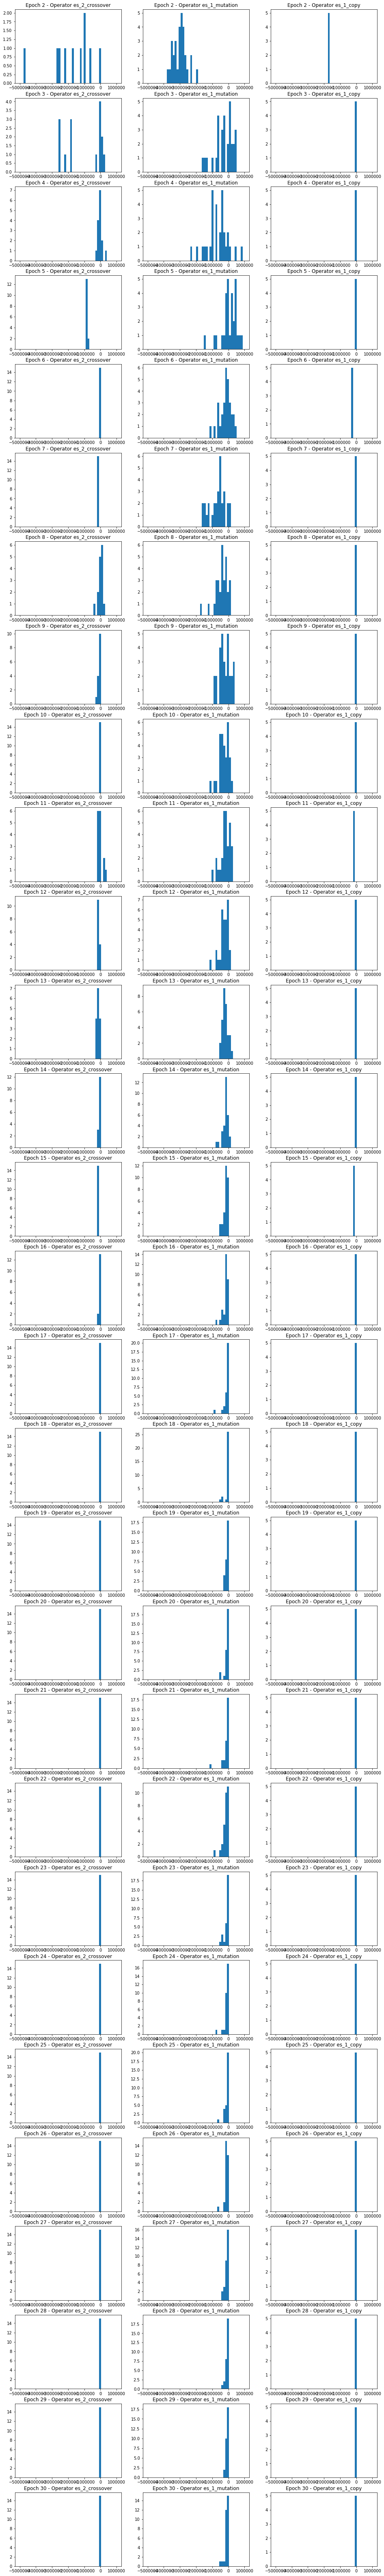

In [12]:
plot_delta_rewards_by_operator(context, hist_range=(-5000000, 1000000), save=True)

In [13]:
test_array = np.array([0.5,0.5,5])
context["epochs"][num_epochs]["models"][0].predict(test_array), game_func(test_array)

(array([[  3.73521013, -48.2904761 ]]), array([  3.5, -44.5]))

# Play Tris

In [ ]:
PLAYER_1 = 1
PLAYER_2 = -1
EMPTY = 0
DRAW = 0
CONTINUE = 2
PLAYERS = [PLAYER_1, PLAYER_2]

class Tris(Game):
    def __init__(self):
        self.board = np.array([np.array([EMPTY for i in range(3)]) for j in range(3)])
        
    def check_win(self):
        # check rows
        board = self.board
        for row in board:
            for player in PLAYERS:
                if np.all(np.equal(row, np.full(3, player))):
                    return player
        
        # check cols
        board = self.board.transpose()
        for row in board:
            for player in PLAYERS:
                if np.all(np.equal(row, np.full(3, player))):
                    return player
                
        # check diagonals
        diags = []
        diags.append(np.array([board[i][i] for i in range(3)]))
        diags.append(np.array([board[i][3 - i - 1] for i in range(3)]))
        for row in diags:
            for player in PLAYERS:
                if np.all(np.equal(row, np.full(3, player))):
                    return player
        
        # check draw
        exist_empty = False
        for row in self.board:
            for cell in row:
                if cell == EMPTY:
                    exist_empty = True
        if not exist_empty:
            return DRAW
        
        return CONTINUE
    
    def extract_move(self, prediction):
        highest_value = -100000
        highest_value_index = -1
        for i,pred in enumerate(prediction):
            if self.board[i//3][i%3] == EMPTY and pred > highest_value:
                highest_value = pred
                highest_value_index = i
        return highest_value_index
    
    def do_move(self, move, player):
        self.board[move//3][move%3] = player
        
    def opposite_board(self):
        return np.array([np.array([PLAYER_2 if self.board[row][col] == PLAYER_1
                                   else PLAYER_1 if self.board[row][col] == PLAYER_2
                                   else EMPTY for col in range(3)]) for row in range(3)])
    
    def play(self, agent_1, agent_2, interactive=False):
        player_turn = np.random.choice(PLAYERS)
        
        if interactive:
            self.print_board() 
        
        result = self.check_win()
        while result == CONTINUE:
            if player_turn == PLAYER_1:
                prediction = agent_1.predict(self.board)
            else:
                prediction = agent_2.predict(self.opposite_board())
              
            move = self.extract_move(prediction)
            self.do_move(move, player_turn)
            
            if interactive:
                self.print_board()
            
            if player_turn == PLAYER_1:
                player_turn = PLAYER_2
            else:
                player_turn = PLAYER_1
                
            result = self.check_win()
            
        if interactive:
                self.print_board()    
        
        return result
    
    def print_board(self):
        for row in self.board:
            for cell in row:
                print(cell, end=" ")
            print("")
        print("-"*30)

In [ ]:
from evoframe.reward_builders.reward_builder_game import TournamentMode

In [ ]:
# Game
game_creation_function = lambda: Tris()

# Model
layer_sizes = [9, 5, 5, 9]
get_model_func = lambda: FeedForwardNetwork(layer_sizes, ActivationFunctions.get_sigmoid(), ActivationFunctions.get_sigmoid())

# Game-Model interface
def predict_func(model, inputs):
    # In Tris, 'inputs' is a 3x3 np.array, thus we must flatten it to a 9x1 np.array
    # output is a 9x1 vector, where the cell with highest value corresponding
    # to a valid move will be the chosen move
    return model.predict(inputs.flatten())[0]
agent_wrapper_func = get_agent_wrapper_func(predict_func)

# Reward function and update env function
# Since Tris is a two-players game, we can compute the reward with a tournament against the current generation
reward_function, update_env_f = RewardBuilderGame() \
.with_game_creation_function(game_creation_function) \
.with_agent_wrapper_func(agent_wrapper_func) \
.with_competitive_tournament(TournamentMode.VS_BEST_OF_EACH_GEN) \
.with_keep_only(30) \
.get()

# Update population function
get_new_pop_f = PopulationUpdateBuilderStatic() \
.add_operator("es_1_mutation", 0.6, 0.3, 0.5) \
.add_operator("es_2_crossover", 0.3, 0.1) \
.add_operator("es_1_copy", 0.1) \
.add_selector_f(SelectorFunctionFactory.get_geometric_selector_function(0.3)) \
.get()

# Population manager
pop_size = 50
pm = PopulationManager(pop_size, get_model_func, reward_function, update_env_f, get_new_pop_f)

# Run population manager
num_epochs = 100
last_pop, env = pm.run(num_epochs)

In [ ]:
plot_rewards(env)

In [ ]:
# Game
game_creation_function = lambda: Tris()

# Model
layer_sizes = [18, 9, 9]
get_model_func = lambda: FeedForwardNetwork(layer_sizes, ActivationFunctions.get_sigmoid(), ActivationFunctions.get_sigmoid())

# Game-Model interface
def predict_func(model, inputs):
    # In Tris, 'inputs' is a 3x3 np.array
    # output is a 9x1 vector, where the cell with highest value corresponding
    # to a valid move will be the chosen move
    board = inputs
    inputs = []
    for row in board:
        for cell in row:
            if cell == PLAYER_1:
                inputs += [1, 0]
            elif cell == PLAYER_2:
                inputs += [0, 1]
            else:
                inputs += [0, 0]
    return model.predict(np.array(inputs))[0]
agent_wrapper_func = get_agent_wrapper_func(predict_func)

# Reward function and update env function
# Since Tris is a two-players game, we can compute the reward with a tournament against the current generation
reward_function, update_env_f = RewardBuilderGame() \
.with_game_creation_function(game_creation_function) \
.with_agent_wrapper_func(agent_wrapper_func) \
.with_competitive_tournament(TournamentMode.VS_BEST_OF_EACH_GEN) \
.with_keep_only(30) \
.get()

# Update population function
get_new_pop_f = PopulationUpdateBuilderStatic() \
.add_operator("es_1_mutation", 0.6, 0.3, 0.5) \
.add_operator("es_2_crossover", 0.3, 0.1) \
.add_operator("es_1_copy", 0.1) \
.add_selector_f(SelectorFunctionFactory.get_geometric_selector_function(0.3)) \
.get()

# Population manager
pop_size = 100
pm = PopulationManager(pop_size, get_model_func, reward_function, update_env_f, get_new_pop_f)

# Run population manager
num_epochs = 300
last_pop, env = pm.run(num_epochs)

In [ ]:
plot_rewards(env)

In [ ]:
class AgentHuman:
    def __init__(self):
        pass
    
    def predict(self, board):
        move = int(input("Select move: "))
        prediction = [1 if i == move else 0 for i in range(9)]
        return prediction

In [ ]:
game = Tris()
game.play(AgentHuman(), agent_wrapper_func(last_pop[0]), interactive=True)

# Func with context

In [ ]:
# Define global context
context = recursively_default_dict()

# Game
game_creation_func = lambda context: GuessPoint(np.array([0.2,0.8,0.5]), np.array([0.4, 0.5, 10]))
game_creation_func = fwc.func_with_context(game_creation_func, context=context)

# Model
layer_sizes = [3, 5, 3]
get_model_func = lambda context: FeedForwardNetwork(layer_sizes, ActivationFunctions.get_sigmoid(), ActivationFunctions.get_id())
get_model_func = fwc.func_with_context(get_model_func, context=context)

# Game-Model interface
predict_func = lambda model, inputs: model.predict(inputs)
agent_wrapper_func = get_agent_wrapper_func(predict_func)

# Reward function and update env function
reward_function = RewardBuilderGame() \
.with_game_creation_function(game_creation_func) \
.with_agent_wrapper_func(agent_wrapper_func) \
.with_context(context) \
.get()

# Update population function
mutation_perc = 0.6
crossover_perc = 0.3
copy_perc = 0.1
get_new_pop_f = PopulationUpdateBuilderStatic() \
.add_operator("es_1_mutation", mutation_perc, 0.3, 0.3) \
.add_operator("es_2_crossover", crossover_perc, 0.8) \
.add_operator("es_1_copy", copy_perc) \
.add_selector_f(SelectorFunctionFactory.get_geometric_selector_function(0.3)) \
.with_context(context) \
.get()

# Population manager
pop_size = 500
pm = PopulationManager(pop_size, get_model_func, reward_function, get_new_pop_f, context)

# Run population manager
num_epochs = 10
last_pop = pm.run(num_epochs)